# Table of Contents
1. [Exploratory Analysis](#exploratory-analysis)
2. [MLR Models](#MLR-Model-and-Finding-Correct-Parameters-for-RDF-Model)
3. [Predictions Part](#Using-Average-Case-to-Make-Predictions)

# Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
data = pd.read_csv("C:/Users/msteinme/Documents/ureamorevariables.csv")
df_96on = data[['Date','Gas','Urea_Inventory','Urea']]
df_96on.tail()

,Date,Gas,Urea_Inventory,Urea
1057,4/8/2016,2.077,300000,248
1058,4/15/2016,1.997,300000,255
1059,4/22/2016,2.267,300000,238
1060,4/29/2016,2.322,300000,232
1061,4/30/2016,2.322,300000,232


In [2]:
from datetime import datetime
df_96on['Date'] = pd.to_datetime(df_96on['Date'])
date = df_96on['Date']
df_96on.dtypes

C:\Users\msteinme\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Date              datetime64[ns]
Gas                      float64
Urea_Inventory             int64
Urea                       int64
dtype: object

In [3]:
df_96on.describe()

,Gas,Urea_Inventory,Urea
count,1062.000000,1062.000000,1062.000000
mean,4.598145,379240.621469,260.028249
std,2.364433,150650.515279,135.620177
min,1.661000,117546.000000,83.000000
25%,2.762500,259783.750000,151.250000
50%,4.025500,359240.500000,240.000000
75%,5.824750,478000.000000,335.000000
max,14.431000,843000.000000,825.000000


In [4]:
df_96on.corr()

,Gas,Urea_Inventory,Urea
Gas,1.000000,-0.243438,0.324833
Urea_Inventory,-0.243438,1.000000,-0.522455
Urea,0.324833,-0.522455,1.000000


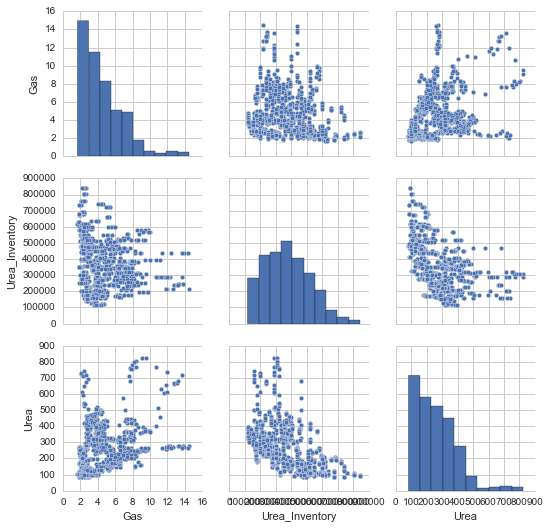

In [5]:
sns.set(style='whitegrid', context='notebook')
sns.pairplot(df_96on, size=2.5);
plt.show()
#only urea_inventory looks relatively normal and the other two are positively skewed

# MLR Model and Finding Correct Parameters for RDF Model
[Top](#table-of-contents)

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
X = df_96on[['Gas','Urea_Inventory']]
Y = df_96on[['Urea']]
X= sm.add_constant(X)
est= sm.OLS(Y,X).fit()
est.summary()
#not even going to include considering this is horrific R^2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Urea   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     242.9
Date:                Fri, 03 Jun 2016   Prob (F-statistic):           1.48e-87
Time:                        11:14:40   Log-Likelihood:                -6520.2
No. Observations:                1062   AIC:                         1.305e+04
Df Residuals:                    1059   BIC:                         1.306e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const            365.5234     13.043     28.024      0.000       339.930   391.117
Gas               12.0509      1.505      8.009      0.000         9.099    15.003
Urea_Inventory    -0.0004   2.36e-05    -17.967      0.000        -0.000    -0.000
==============================================================================
Omnibus:                      263.582   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              595.992
Skew:                           1.356   Prob(JB):                    3.82e-130
Kurtosis:                       5.473   Cond. No.                     1.55e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
X = df_96on[['Gas','Urea_Inventory']].values
y = df_96on['Urea'].values
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=1)

In [8]:
from sklearn import metrics
from sklearn import grid_search
from sklearn.grid_search import GridSearchCV

def fit_predict_model(X_train,y_train,):
    """Find and tune the optimal model. Make a prediction on urea data"""
    
    # Setup a Random Forest Regressor
    regressor = RandomForestRegressor()

    parameters = {'n_estimators':(100,125,150,175,200),
                  'max_depth':(5,6,7,8,9,10)}

    mse_scorer = metrics.make_scorer(metrics.mean_squared_error, greater_is_better = False)
    
    # use grid search to fine tune the RandomForests Regressor and
    # obtain the parameters that generate the best training performance. 
    reg = grid_search.GridSearchCV(regressor, param_grid=parameters,
                                   scoring=mse_scorer, cv = 10)
    
    # Fit the learner to the training data to obtain the best parameter set
    print ("Final Model: ")
    print (reg.fit(X_train, y_train))
    return reg

In [12]:
#do multiple times to see what parameters are the best
rdf_model_ureagasinv = fit_predict_model(X_train,y_train)
print (rdf_model_ureagasinv.best_estimator_)

Final Model: 
GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (100, 125, 150, 175, 200), 'max_depth': (5, 6, 7, 8, 9, 10)},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


In [19]:
X = df_96on[['Gas','Urea_Inventory']].values
y = df_96on['Urea'].values
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=1)
forest=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
forest.fit(X_train, y_train)
y_train_pred= forest.predict(X_train)
y_test_pred= forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),r2_score(y_test,y_test_pred)))
print(forest.feature_importances_)
#big MSE and bad R^2 for the test set

MSE train: 1342.489, test: 3783.308
R^2 train: 0.929, test: 0.781
[ 0.36012776  0.63987224]


# Using Average Case to Make Predictions
[Top](#table-of-contents)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
data = pd.read_csv("C:/Users/msteinme/Documents/ureaaprilavgrandomness.csv")
df_96on = data[['Date','Gas','Urea_Inventory','Urea']][0:1062]
df_96on.tail()
#1/5/1996 - 4/30/2016

,Date,Gas,Urea_Inventory,Urea
1057,4/8/2016,2.08,537504.7397,248.0
1058,4/15/2016,2.00,537504.7397,255.0
1059,4/22/2016,2.27,537504.7397,238.0
1060,4/29/2016,2.32,537504.7397,232.0
1061,4/30/2016,2.32,537504.7397,232.0


In [21]:
from datetime import datetime
df_96on['Date'] = pd.to_datetime(df_96on['Date'])
date = df_96on['Date']
df_96on.dtypes

Date              datetime64[ns]
Gas                      float64
Urea_Inventory           float64
Urea                     float64
dtype: object

In [22]:
df_96on.describe()

,Gas,Urea_Inventory,Urea
count,1062.000000,1062.000000,1062.000000
mean,4.598559,379668.241622,260.028249
std,2.364318,151925.723394,135.620177
min,1.660000,115938.863000,83.000000
25%,2.760000,255962.678600,151.250000
50%,4.025000,368370.238100,240.000000
75%,5.825000,479692.000000,335.000000
max,14.430000,843000.000000,825.000000


In [23]:
X = df_96on[['Gas','Urea_Inventory']].values
y = df_96on['Urea'].values
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=1)
forest=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
forest.fit(X_train, y_train)
y_train_pred= forest.predict(X_train)
y_test_pred= forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),r2_score(y_test,y_test_pred)))
print(forest.feature_importances_)

MSE train: 1400.442, test: 4054.960
R^2 train: 0.926, test: 0.766
[ 0.36018819  0.63981181]


In [25]:
urea_predicted2 = forest.predict(X)
urea_predicted2 = pd.DataFrame(urea_predicted2)
df_96on['Urea_RDF_GasInv'] = urea_predicted2
rdf_error2 = (abs(df_96on['Urea_RDF_GasInv'] - df_96on['Urea'])/df_96on['Urea'])*100
df_96on['RDF_GasInv_Error'] = rdf_error2

print("Average RDF Gas Urea Inventory error is: %.3f" % (rdf_error2.mean()))

df_96on

Average RDF Gas Urea Inventory error is: 12.266


,Date,Gas,Urea_Inventory,Urea,Urea_RDF_GasInv,RDF_GasInv_Error
0,1996-01-05,2.42,589898.9899,220.0,165.376917,24.828674
1,1996-01-12,2.22,589898.9899,220.0,161.486568,26.597014
2,1996-01-19,1.96,589898.9899,218.0,169.067867,22.445933
3,1996-01-26,1.95,589898.9899,215.0,168.696867,21.536341
4,1996-02-02,2.08,609090.9091,205.0,185.980540,9.277786
5,1996-02-09,2.24,609090.9091,205.0,158.029584,22.912398
6,1996-02-16,2.17,609090.9091,210.0,160.860498,23.399763
7,1996-02-23,2.26,609090.9091,210.0,157.172358,25.156020
8,1996-03-01,2.06,681818.1818,210.0,180.966162,13.825637
9,1996-03-08,2.05,681818.1818,205.0,181.487273,11.469623


In [29]:
#predictions section 5/1/2016 - 12/31/2020
newpred2 = data[['Date','Gas','Urea_Inventory']][1062:2768]
newpred = data [['Gas','Urea_Inventory']][1062:2768]

In [30]:
X = df_96on[['Gas','Urea_Inventory']].values
y = df_96on['Urea'].values
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=1)
forest=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
forest.fit(X_train, y_train)
y_train_pred= forest.predict(X_train)
y_test_pred= forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),r2_score(y_test,y_test_pred)))
print(forest.feature_importances_)

newpred2 = np.array(newpred2)
newpred2 = pd.DataFrame(newpred2)
newpred2.columns = ['Date','Gas','Urea_Inventory']
newpred_predicted = forest.predict(newpred)
df_new_pred = pd.DataFrame(newpred_predicted)
newpred2['Urea_RDF_GasInv'] = df_new_pred

newpred2['Date'] = pd.to_datetime(newpred2['Date'])
newpred2

MSE train: 1521.042, test: 4394.387
R^2 train: 0.919, test: 0.746
[ 0.3639769  0.6360231]


,Date,Gas,Urea_Inventory,Urea_RDF_GasInv
0,2016-05-01,2.32,539603,210.890267
1,2016-05-02,2.18,539603,196.615817
2,2016-05-03,2.3,539603,196.885824
3,2016-05-04,2.21,539603,193.404392
4,2016-05-05,2.13,539603,202.803128
5,2016-05-06,2.29,539603,200.695824
6,2016-05-07,2.25,539603,194.551265
7,2016-05-08,2.23,539603,192.564218
8,2016-05-09,2.12,539603,202.803128
9,2016-05-10,2.13,539603,202.803128


In [31]:
frames = [df_96on,newpred2]
combined = pd.concat(frames)
combined

,Date,Gas,RDF_GasInv_Error,Urea,Urea_Inventory,Urea_RDF_GasInv
0,1996-01-05,2.42,24.828674,220.0,589899,165.376917
1,1996-01-12,2.22,26.597014,220.0,589899,161.486568
2,1996-01-19,1.96,22.445933,218.0,589899,169.067867
3,1996-01-26,1.95,21.536341,215.0,589899,168.696867
4,1996-02-02,2.08,9.277786,205.0,609091,185.980540
5,1996-02-09,2.24,22.912398,205.0,609091,158.029584
6,1996-02-16,2.17,23.399763,210.0,609091,160.860498
7,1996-02-23,2.26,25.156020,210.0,609091,157.172358
8,1996-03-01,2.06,13.825637,210.0,681818,180.966162
9,1996-03-08,2.05,11.469623,205.0,681818,181.487273


In [32]:
combined = combined[['Date','Gas','Urea_Inventory','Urea','Urea_RDF_GasInv']]
combined = np.array(combined)
combined = pd.DataFrame(combined)
combined.columns = ['Date','Gas','Urea_Inventory','Urea','Urea_RDF_GasInv']
combined

,Date,Gas,Urea_Inventory,Urea,Urea_RDF_GasInv
0,1996-01-05 00:00:00,2.42,589899,220,165.377
1,1996-01-12 00:00:00,2.22,589899,220,161.487
2,1996-01-19 00:00:00,1.96,589899,218,169.068
3,1996-01-26 00:00:00,1.95,589899,215,168.697
4,1996-02-02 00:00:00,2.08,609091,205,185.981
5,1996-02-09 00:00:00,2.24,609091,205,158.03
6,1996-02-16 00:00:00,2.17,609091,210,160.86
7,1996-02-23 00:00:00,2.26,609091,210,157.172
8,1996-03-01 00:00:00,2.06,681818,210,180.966
9,1996-03-08 00:00:00,2.05,681818,205,181.487


In [33]:
combined.to_csv("C:/Users/msteinme/Documents/ureaaprilavgresultsgasinv.csv")

In [34]:
#split into months
cols = ['Date','Gas','Urea_Inventory','Urea','Urea_RDF_GasInv']
jan_96 = combined[cols][0:4]
feb_96 = combined[cols][4:8]
mar_96 = combined[cols][8:13]
apr_96 = combined[cols][13:17]
may_96 = combined[cols][17:22]
jun_96 = combined[cols][22:26]
jul_96 = combined[cols][26:30]
aug_96 = combined[cols][30:35]
sep_96 = combined[cols][35:39]
oct_96 = combined[cols][39:43]
nov_96 = combined[cols][43:48]
dec_96 = combined[cols][48:52]
jan_97 = combined[cols][52:57]
feb_97 = combined[cols][57:61]
mar_97 = combined[cols][61:65]
apr_97 = combined[cols][65:69]
may_97 = combined[cols][69:74]
jun_97 = combined[cols][74:78]
jul_97 = combined[cols][78:82]
aug_97 = combined[cols][82:87]
sep_97 = combined[cols][87:91]
oct_97 = combined[cols][91:96]
nov_97 = combined[cols][96:100]
dec_97 = combined[cols][100:104]
jan_98 = combined[cols][104:109]
feb_98 = combined[cols][109:113]
mar_98 = combined[cols][113:117]
apr_98 = combined[cols][117:121]
may_98 = combined[cols][121:126]
jun_98 = combined[cols][126:130]
jul_98 = combined[cols][130:135]
aug_98 = combined[cols][135:139]
sep_98 = combined[cols][139:143]
oct_98 = combined[cols][143:148]
nov_98 = combined[cols][148:152]
dec_98 = combined[cols][152:156]
jan_99 = combined[cols][156:161]
feb_99 = combined[cols][161:165]
mar_99 = combined[cols][165:169]
apr_99 = combined[cols][169:174]
may_99 = combined[cols][174:178]
jun_99 = combined[cols][178:182]
jul_99 = combined[cols][182:187]
aug_99 = combined[cols][187:191]
sep_99 = combined[cols][191:195]
oct_99 = combined[cols][195:200]
nov_99 = combined[cols][200:204]
dec_99 = combined[cols][204:209]
jan_00 = combined[cols][209:213]
feb_00 = combined[cols][213:217]
mar_00 = combined[cols][217:222]
apr_00 = combined[cols][222:226]
may_00 = combined[cols][226:230]
jun_00 = combined[cols][230:235]
jul_00 = combined[cols][235:239]
aug_00 = combined[cols][239:243]
sep_00 = combined[cols][243:248]
oct_00 = combined[cols][248:252]
nov_00 = combined[cols][252:256]
dec_00 = combined[cols][256:261]
jan_01 = combined[cols][261:265]
feb_01 = combined[cols][265:269]
mar_01 = combined[cols][269:274]
apr_01 = combined[cols][274:278]
may_01 = combined[cols][278:282]
jun_01 = combined[cols][282:287]
jul_01 = combined[cols][287:291]
aug_01 = combined[cols][291:296]
sep_01 = combined[cols][296:300]
oct_01 = combined[cols][300:304]
nov_01 = combined[cols][304:309]
dec_01 = combined[cols][309:313]
jan_02 = combined[cols][313:317]
feb_02 = combined[cols][317:321]
mar_02 = combined[cols][321:326]
apr_02 = combined[cols][326:330]
may_02 = combined[cols][330:335]
jun_02 = combined[cols][335:339]
jul_02 = combined[cols][339:343]
aug_02 = combined[cols][343:348]
sep_02 = combined[cols][348:352]
oct_02 = combined[cols][352:356]
nov_02 = combined[cols][356:361]
dec_02 = combined[cols][361:365]
jan_03 = combined[cols][365:370]
feb_03 = combined[cols][370:374]
mar_03 = combined[cols][374:378]
apr_03 = combined[cols][378:382]
may_03 = combined[cols][382:387]
jun_03 = combined[cols][387:391]
jul_03 = combined[cols][391:395]
aug_03 = combined[cols][395:400]
sep_03 = combined[cols][400:404]
oct_03 = combined[cols][404:409]
nov_03 = combined[cols][409:413]
dec_03 = combined[cols][413:417]
jan_04 = combined[cols][417:422]
feb_04 = combined[cols][422:426]
mar_04 = combined[cols][426:430]
apr_04 = combined[cols][430:435]
may_04 = combined[cols][435:439]
jun_04 = combined[cols][439:443]
jul_04 = combined[cols][443:448]
aug_04 = combined[cols][448:452]
sep_04 = combined[cols][452:456]
oct_04 = combined[cols][456:461]
nov_04 = combined[cols][461:465]
dec_04 = combined[cols][465:470]
jan_05 = combined[cols][470:474]
feb_05 = combined[cols][474:478]
mar_05 = combined[cols][478:482]
apr_05 = combined[cols][482:487]
may_05 = combined[cols][487:491]
jun_05 = combined[cols][491:495]
jul_05 = combined[cols][495:500]
aug_05 = combined[cols][500:504]
sep_05 = combined[cols][504:509]
oct_05 = combined[cols][509:513]
nov_05 = combined[cols][513:517]
dec_05 = combined[cols][517:522]
jan_06 = combined[cols][522:526]
feb_06 = combined[cols][526:530]
mar_06 = combined[cols][530:535]
apr_06 = combined[cols][535:539]
may_06 = combined[cols][539:543]
jun_06 = combined[cols][543:548]
jul_06 = combined[cols][548:552]
aug_06 = combined[cols][552:556]
sep_06 = combined[cols][556:561]
oct_06 = combined[cols][561:565]
nov_06 = combined[cols][565:569]
dec_06 = combined[cols][569:574]
jan_07 = combined[cols][574:578]
feb_07 = combined[cols][578:582]
mar_07 = combined[cols][582:587]
apr_07 = combined[cols][587:591]
may_07 = combined[cols][591:595]
jun_07 = combined[cols][595:600]
jul_07 = combined[cols][600:604]
aug_07 = combined[cols][604:609]
sep_07 = combined[cols][609:613]
oct_07 = combined[cols][613:617]
nov_07 = combined[cols][617:622]
dec_07 = combined[cols][622:626]
jan_08 = combined[cols][626:630]
feb_08 = combined[cols][630:635]
mar_08 = combined[cols][635:639]
apr_08 = combined[cols][639:643]
may_08 = combined[cols][643:648]
jun_08 = combined[cols][648:652]
jul_08 = combined[cols][652:656]
aug_08 = combined[cols][656:661]
sep_08 = combined[cols][661:665]
oct_08 = combined[cols][665:670]
nov_08 = combined[cols][670:674]
dec_08 = combined[cols][674:678]
jan_09 = combined[cols][678:683]
feb_09 = combined[cols][683:687]
mar_09 = combined[cols][687:691]
apr_09 = combined[cols][691:695]
may_09 = combined[cols][695:700]
jun_09 = combined[cols][700:704]
jul_09 = combined[cols][704:709]
aug_09 = combined[cols][709:713]
sep_09 = combined[cols][713:717]
oct_09 = combined[cols][717:722]
nov_09 = combined[cols][722:726]
dec_09 = combined[cols][726:730]
jan_10 = combined[cols][730:735]
feb_10 = combined[cols][735:739]
mar_10 = combined[cols][739:743]
apr_10 = combined[cols][743:748]
may_10 = combined[cols][748:752]
jun_10 = combined[cols][752:756]
jul_10 = combined[cols][756:761]
aug_10 = combined[cols][761:765]
sep_10 = combined[cols][765:769]
oct_10 = combined[cols][769:774]
nov_10 = combined[cols][774:778]
dec_10 = combined[cols][778:783]
jan_11 = combined[cols][783:787]
feb_11 = combined[cols][787:791]
mar_11 = combined[cols][791:795]
apr_11 = combined[cols][795:800]
may_11 = combined[cols][800:804]
jun_11 = combined[cols][804:808]
jul_11 = combined[cols][808:813]
aug_11 = combined[cols][813:817]
sep_11 = combined[cols][817:822]
oct_11 = combined[cols][822:826]
nov_11 = combined[cols][826:830]
dec_11 = combined[cols][830:835]
jan_12 = combined[cols][835:839]
feb_12 = combined[cols][839:843]
mar_12 = combined[cols][843:848]
apr_12 = combined[cols][848:852]
may_12 = combined[cols][852:856]
jun_12 = combined[cols][856:861]
jul_12 = combined[cols][861:865]
aug_12 = combined[cols][865:870]
sep_12 = combined[cols][870:874]
oct_12 = combined[cols][874:878]
nov_12 = combined[cols][878:883]
dec_12 = combined[cols][883:887]
jan_13 = combined[cols][887:891]
feb_13 = combined[cols][891:895]
mar_13 = combined[cols][895:900]
apr_13 = combined[cols][900:904]
may_13 = combined[cols][904:909]
jun_13 = combined[cols][909:913]
jul_13 = combined[cols][913:917]
aug_13 = combined[cols][917:922]
sep_13 = combined[cols][922:926]
oct_13 = combined[cols][926:930]
nov_13 = combined[cols][930:935]
dec_13 = combined[cols][935:939]
jan_14 = combined[cols][939:944]
feb_14 = combined[cols][944:948]
mar_14 = combined[cols][948:952]
apr_14 = combined[cols][952:956]
may_14 = combined[cols][956:961]
jun_14 = combined[cols][961:965]
jul_14 = combined[cols][965:969]
aug_14 = combined[cols][969:974]
sep_14 = combined[cols][974:978]
oct_14 = combined[cols][978:983]
nov_14 = combined[cols][983:987]
dec_14 = combined[cols][987:991]
jan_15 = combined[cols][991:996]
feb_15 = combined[cols][996:1000]
mar_15 = combined[cols][1000:1004]
apr_15 = combined[cols][1004:1008]
may_15 = combined[cols][1008:1013]
jun_15 = combined[cols][1013:1017]
jul_15 = combined[cols][1017:1022]
aug_15 = combined[cols][1022:1026]
sep_15 = combined[cols][1026:1030]
oct_15 = combined[cols][1030:1035]
nov_15 = combined[cols][1035:1039]
dec_15 = combined[cols][1039:1043]
jan_16 = combined[cols][1043:1048]
feb_16 = combined[cols][1048:1052]
mar_16 = combined[cols][1052:1056]
apr_16 = combined[cols][1056:1062]

#predicted part
may_16 = combined[cols][1062:1093]
jun_16 = combined[cols][1093:1123]
jul_16 = combined[cols][1123:1154]
aug_16 = combined[cols][1154:1185]
sep_16 = combined[cols][1185:1215]
oct_16 = combined[cols][1215:1246]
nov_16 = combined[cols][1246:1276]
dec_16 = combined[cols][1276:1307]
jan_17 = combined[cols][1307:1338]
feb_17 = combined[cols][1338:1366]
mar_17 = combined[cols][1366:1397]
apr_17 = combined[cols][1397:1427]
may_17 = combined[cols][1427:1458]
jun_17 = combined[cols][1458:1488]
jul_17 = combined[cols][1488:1519]
aug_17 = combined[cols][1519:1550]
sep_17 = combined[cols][1550:1580]
oct_17 = combined[cols][1580:1611]
nov_17 = combined[cols][1611:1641]
dec_17 = combined[cols][1641:1672]
jan_18 = combined[cols][1672:1703]
feb_18 = combined[cols][1703:1731]
mar_18 = combined[cols][1731:1762]
apr_18 = combined[cols][1762:1792]
may_18 = combined[cols][1792:1823]
jun_18 = combined[cols][1823:1853]
jul_18 = combined[cols][1853:1884]
aug_18 = combined[cols][1884:1915]
sep_18 = combined[cols][1915:1945]
oct_18 = combined[cols][1945:1976]
nov_18 = combined[cols][1976:2006]
dec_18 = combined[cols][2006:2037]
jan_19 = combined[cols][2037:2068]
feb_19 = combined[cols][2068:2096]
mar_19 = combined[cols][2096:2127]
apr_19 = combined[cols][2127:2157]
may_19 = combined[cols][2157:2188]
jun_19 = combined[cols][2188:2218]
jul_19 = combined[cols][2218:2249]
aug_19 = combined[cols][2249:2280]
sep_19 = combined[cols][2280:2310]
oct_19 = combined[cols][2310:2341]
nov_19 = combined[cols][2341:2371]
dec_19 = combined[cols][2371:2402]
jan_20 = combined[cols][2402:2433]
feb_20 = combined[cols][2433:2462]
mar_20 = combined[cols][2462:2493]
apr_20 = combined[cols][2493:2523]
may_20 = combined[cols][2523:2554]
jun_20 = combined[cols][2554:2584]
jul_20 = combined[cols][2584:2615]
aug_20 = combined[cols][2615:2646]
sep_20 = combined[cols][2646:2676]
oct_20 = combined[cols][2676:2707]
nov_20 = combined[cols][2707:2737]
dec_20 = combined[cols][2737:2768]

In [35]:
mycolumns = ['Gas','Urea_Inventory','Urea','Urea_RDF_GasInv']
df = pd.DataFrame(columns=mycolumns)
rows = [jan_96[mycolumns].mean(),feb_96[mycolumns].mean(),
        mar_96[mycolumns].mean(),apr_96[mycolumns].mean(),may_96[mycolumns].mean(),jun_96[mycolumns].mean(),
        jul_96[mycolumns].mean(),aug_96[mycolumns].mean(),sep_96[mycolumns].mean(),oct_96[mycolumns].mean(),nov_96[mycolumns].mean(),dec_96[mycolumns].mean(),
        jan_97[mycolumns].mean(),feb_97[mycolumns].mean(),mar_97[mycolumns].mean(),apr_97[mycolumns].mean(),may_97[mycolumns].mean(),jun_97[mycolumns].mean(),
        jul_97[mycolumns].mean(),aug_97[mycolumns].mean(),sep_97[mycolumns].mean(),oct_97[mycolumns].mean(),nov_97[mycolumns].mean(),dec_97[mycolumns].mean(),
        jan_98[mycolumns].mean(),feb_98[mycolumns].mean(),mar_98[mycolumns].mean(),apr_98[mycolumns].mean(),may_98[mycolumns].mean(),jun_98[mycolumns].mean(),
        jul_98[mycolumns].mean(),aug_98[mycolumns].mean(),sep_98[mycolumns].mean(),oct_98[mycolumns].mean(),nov_98[mycolumns].mean(),dec_98[mycolumns].mean(),
        jan_99[mycolumns].mean(),feb_99[mycolumns].mean(),mar_99[mycolumns].mean(),apr_99[mycolumns].mean(),may_99[mycolumns].mean(),jun_99[mycolumns].mean(),
        jul_99[mycolumns].mean(),aug_99[mycolumns].mean(),sep_99[mycolumns].mean(),oct_99[mycolumns].mean(),nov_99[mycolumns].mean(),dec_99[mycolumns].mean(),
        jan_00[mycolumns].mean(),feb_00[mycolumns].mean(),mar_00[mycolumns].mean(),apr_00[mycolumns].mean(),may_00[mycolumns].mean(),jun_00[mycolumns].mean(),
        jul_00[mycolumns].mean(),aug_00[mycolumns].mean(),sep_00[mycolumns].mean(),oct_00[mycolumns].mean(),nov_00[mycolumns].mean(),dec_00[mycolumns].mean(),
        jan_01[mycolumns].mean(),feb_01[mycolumns].mean(),mar_01[mycolumns].mean(),apr_01[mycolumns].mean(),may_01[mycolumns].mean(),jun_01[mycolumns].mean(),
        jul_01[mycolumns].mean(),aug_01[mycolumns].mean(),sep_01[mycolumns].mean(),oct_01[mycolumns].mean(),nov_01[mycolumns].mean(),dec_01[mycolumns].mean(),
        jan_02[mycolumns].mean(),feb_02[mycolumns].mean(),mar_02[mycolumns].mean(),apr_02[mycolumns].mean(),may_02[mycolumns].mean(),jun_02[mycolumns].mean(),
        jul_02[mycolumns].mean(),aug_02[mycolumns].mean(),sep_02[mycolumns].mean(),oct_02[mycolumns].mean(),nov_02[mycolumns].mean(),dec_02[mycolumns].mean(),
        jan_03[mycolumns].mean(),feb_03[mycolumns].mean(),mar_03[mycolumns].mean(),apr_03[mycolumns].mean(),may_03[mycolumns].mean(),jun_03[mycolumns].mean(),
        jul_03[mycolumns].mean(),aug_03[mycolumns].mean(),sep_03[mycolumns].mean(),oct_03[mycolumns].mean(),nov_03[mycolumns].mean(),dec_03[mycolumns].mean(),
        jan_04[mycolumns].mean(),feb_04[mycolumns].mean(),mar_04[mycolumns].mean(),apr_04[mycolumns].mean(),may_04[mycolumns].mean(),jun_04[mycolumns].mean(),
        jul_04[mycolumns].mean(),aug_04[mycolumns].mean(),sep_04[mycolumns].mean(),oct_04[mycolumns].mean(),nov_04[mycolumns].mean(),dec_04[mycolumns].mean(),
        jan_05[mycolumns].mean(),feb_05[mycolumns].mean(),mar_05[mycolumns].mean(),apr_05[mycolumns].mean(),may_05[mycolumns].mean(),jun_05[mycolumns].mean(),
        jul_05[mycolumns].mean(),aug_05[mycolumns].mean(),sep_05[mycolumns].mean(),oct_05[mycolumns].mean(),nov_05[mycolumns].mean(),dec_05[mycolumns].mean(),
        jan_06[mycolumns].mean(),feb_06[mycolumns].mean(),mar_06[mycolumns].mean(),apr_06[mycolumns].mean(),may_06[mycolumns].mean(),jun_06[mycolumns].mean(),
        jul_06[mycolumns].mean(),aug_06[mycolumns].mean(),sep_06[mycolumns].mean(),oct_06[mycolumns].mean(),nov_06[mycolumns].mean(),dec_06[mycolumns].mean(),
        jan_07[mycolumns].mean(),feb_07[mycolumns].mean(),mar_07[mycolumns].mean(),apr_07[mycolumns].mean(),may_07[mycolumns].mean(),jun_07[mycolumns].mean(),
        jul_07[mycolumns].mean(),aug_07[mycolumns].mean(),sep_07[mycolumns].mean(),oct_07[mycolumns].mean(),nov_07[mycolumns].mean(),dec_07[mycolumns].mean(),
        jan_08[mycolumns].mean(),feb_08[mycolumns].mean(),mar_08[mycolumns].mean(),apr_08[mycolumns].mean(),may_08[mycolumns].mean(),jun_08[mycolumns].mean(),
        jul_08[mycolumns].mean(),aug_08[mycolumns].mean(),sep_08[mycolumns].mean(),oct_08[mycolumns].mean(),nov_08[mycolumns].mean(),dec_08[mycolumns].mean(),
        jan_09[mycolumns].mean(),feb_09[mycolumns].mean(),mar_09[mycolumns].mean(),apr_09[mycolumns].mean(),may_09[mycolumns].mean(),jun_09[mycolumns].mean(),
        jul_09[mycolumns].mean(),aug_09[mycolumns].mean(),sep_09[mycolumns].mean(),oct_09[mycolumns].mean(),nov_09[mycolumns].mean(),dec_09[mycolumns].mean(),
        jan_10[mycolumns].mean(),feb_10[mycolumns].mean(),mar_10[mycolumns].mean(),apr_10[mycolumns].mean(),may_10[mycolumns].mean(),jun_10[mycolumns].mean(),
        jul_10[mycolumns].mean(),aug_10[mycolumns].mean(),sep_10[mycolumns].mean(),oct_10[mycolumns].mean(),nov_10[mycolumns].mean(),dec_10[mycolumns].mean(),
        jan_11[mycolumns].mean(),feb_11[mycolumns].mean(),mar_11[mycolumns].mean(),apr_11[mycolumns].mean(),may_11[mycolumns].mean(),jun_11[mycolumns].mean(),
        jul_11[mycolumns].mean(),aug_11[mycolumns].mean(),sep_11[mycolumns].mean(),oct_11[mycolumns].mean(),nov_11[mycolumns].mean(),dec_11[mycolumns].mean(),
        jan_12[mycolumns].mean(),feb_12[mycolumns].mean(),mar_12[mycolumns].mean(),apr_12[mycolumns].mean(),may_12[mycolumns].mean(),jun_12[mycolumns].mean(),
        jul_12[mycolumns].mean(),aug_12[mycolumns].mean(),sep_12[mycolumns].mean(),oct_12[mycolumns].mean(),nov_12[mycolumns].mean(),dec_12[mycolumns].mean(),
        jan_13[mycolumns].mean(),feb_13[mycolumns].mean(),mar_13[mycolumns].mean(),apr_13[mycolumns].mean(),may_13[mycolumns].mean(),jun_13[mycolumns].mean(),
        jul_13[mycolumns].mean(),aug_13[mycolumns].mean(),sep_13[mycolumns].mean(),oct_13[mycolumns].mean(),nov_13[mycolumns].mean(),dec_13[mycolumns].mean(),
        jan_14[mycolumns].mean(),feb_14[mycolumns].mean(),mar_14[mycolumns].mean(),apr_14[mycolumns].mean(),may_14[mycolumns].mean(),jun_14[mycolumns].mean(),
        jul_14[mycolumns].mean(),aug_14[mycolumns].mean(),sep_14[mycolumns].mean(),oct_14[mycolumns].mean(),nov_14[mycolumns].mean(),dec_14[mycolumns].mean(),
        jan_15[mycolumns].mean(),feb_15[mycolumns].mean(),mar_15[mycolumns].mean(),apr_15[mycolumns].mean(),may_15[mycolumns].mean(),jun_15[mycolumns].mean(),
        jul_15[mycolumns].mean(),aug_15[mycolumns].mean(),sep_15[mycolumns].mean(),oct_15[mycolumns].mean(),nov_15[mycolumns].mean(),dec_15[mycolumns].mean(),
        jan_16[mycolumns].mean(),feb_16[mycolumns].mean(),mar_16[mycolumns].mean(),apr_16[mycolumns].mean(),may_16[mycolumns].mean(),jun_16[mycolumns].mean(),
        jul_16[mycolumns].mean(),aug_16[mycolumns].mean(),sep_16[mycolumns].mean(),oct_16[mycolumns].mean(),nov_16[mycolumns].mean(),dec_16[mycolumns].mean(),
        jan_17[mycolumns].mean(),feb_17[mycolumns].mean(),mar_17[mycolumns].mean(),apr_17[mycolumns].mean(),may_17[mycolumns].mean(),jun_17[mycolumns].mean(),
        jul_17[mycolumns].mean(),aug_17[mycolumns].mean(),sep_17[mycolumns].mean(),oct_17[mycolumns].mean(),nov_17[mycolumns].mean(),dec_17[mycolumns].mean(),
        jan_18[mycolumns].mean(),feb_18[mycolumns].mean(),mar_18[mycolumns].mean(),apr_18[mycolumns].mean(),may_18[mycolumns].mean(),jun_18[mycolumns].mean(),
        jul_18[mycolumns].mean(),aug_18[mycolumns].mean(),sep_18[mycolumns].mean(),oct_18[mycolumns].mean(),nov_18[mycolumns].mean(),dec_18[mycolumns].mean(),
        jan_19[mycolumns].mean(),feb_19[mycolumns].mean(),mar_19[mycolumns].mean(),apr_19[mycolumns].mean(),may_19[mycolumns].mean(),jun_19[mycolumns].mean(),
        jul_19[mycolumns].mean(),aug_19[mycolumns].mean(),sep_19[mycolumns].mean(),oct_19[mycolumns].mean(),nov_19[mycolumns].mean(),dec_19[mycolumns].mean(),
        jan_20[mycolumns].mean(),feb_20[mycolumns].mean(),mar_20[mycolumns].mean(),apr_20[mycolumns].mean(),may_20[mycolumns].mean(),jun_20[mycolumns].mean(),
        jul_20[mycolumns].mean(),aug_20[mycolumns].mean(),sep_20[mycolumns].mean(),oct_20[mycolumns].mean(),nov_20[mycolumns].mean(),dec_20[mycolumns].mean()]
#puts each of those values for each of the rows
for row in rows:
    df.loc[len(df)] = row
df.tail() 

,Gas,Urea_Inventory,Urea,Urea_RDF_GasInv
295,3.834839,436000.0,NaN,333.928551
296,3.809333,436000.0,NaN,333.119968
297,3.819677,436000.0,NaN,336.208887
298,3.823000,436000.0,NaN,332.518948
299,3.810323,436000.0,NaN,334.222718


In [36]:
#creating monthly dates in datetime form from 1/1996 to 12/2020
from datetime import datetime
rng2 = pd.date_range(start='1996-01-01', periods=302, freq='M')
rng2
rng2 = pd.DataFrame(rng2)
df['Monthly_Date']= rng2

In [37]:
print(df.dtypes)
df.tail()

Gas                       float64
Urea_Inventory            float64
Urea                      float64
Urea_RDF_GasInv           float64
Monthly_Date       datetime64[ns]
dtype: object


,Gas,Urea_Inventory,Urea,Urea_RDF_GasInv,Monthly_Date
295,3.834839,436000.0,NaN,333.928551,2020-08-31
296,3.809333,436000.0,NaN,333.119968,2020-09-30
297,3.819677,436000.0,NaN,336.208887,2020-10-31
298,3.823000,436000.0,NaN,332.518948,2020-11-30
299,3.810323,436000.0,NaN,334.222718,2020-12-31


In [38]:
df.to_csv("C:/Users/msteinme/Documents/ureaaprilavgresultsmonthlygasinv.csv")

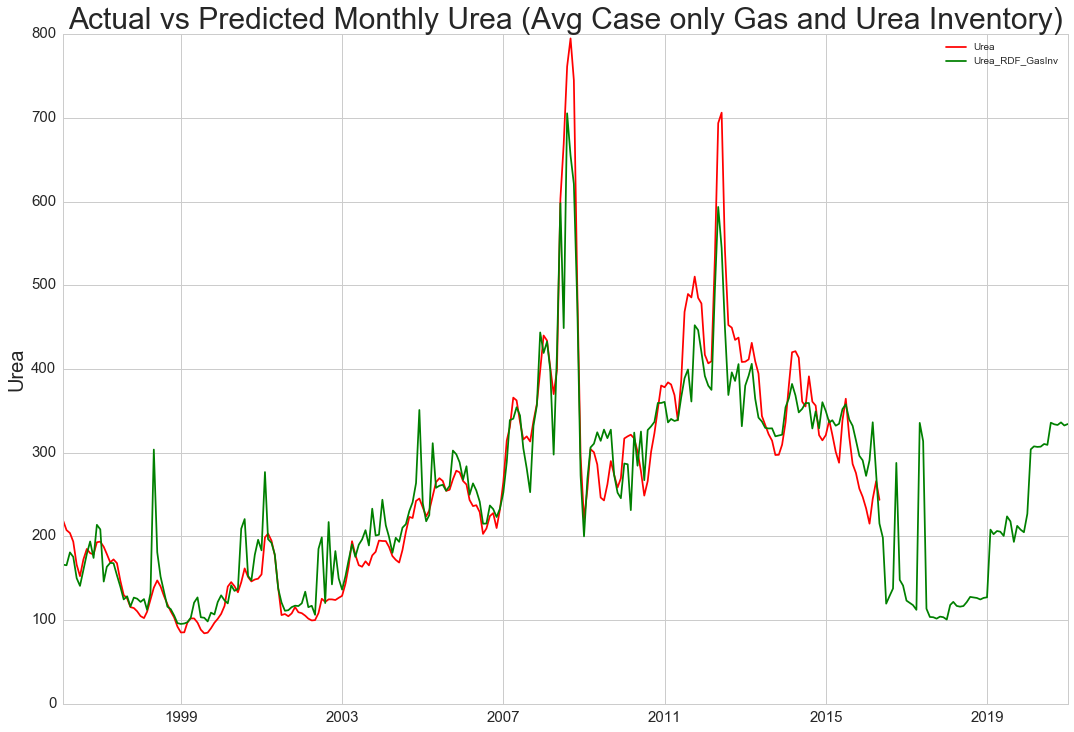

In [39]:
#looking at actual vs predicted monthly
import matplotlib.pyplot as plt
%matplotlib inline

x = (df['Monthly_Date'])
#x_pred = (df['Monthly_Date'][243:])
y1 = (df['Urea'])
y2 = (df['Urea_RDF_GasInv'])

fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111)
ax.plot(x,y1,'r')
ax.plot(x,y2,'g')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_title('Actual vs Predicted Monthly Urea (Avg Case only Gas and Urea Inventory)', size=(30))
ax.tick_params(axis='x',which='major',labelsize=15)
ax.tick_params(axis='y',which='major',labelsize=15)
ax.set_ylabel('Urea',size=(20))

plt.show()